In [1]:
from pymongo import MongoClient
from stm import atomically
from concurrent.futures import ThreadPoolExecutor

import time
import os
import matplotlib.pyplot as plt
import math

Конфігурація та підключення до бази даних

In [2]:
MONGODB_URI = os.environ.get("MONGODB_URI", "mongodb://localhost:27017")
client = MongoClient(MONGODB_URI, username="root", password="root")
db = client.cafes
cafes = db.cafes

Тестові операції для роботи з СУБД

In [3]:
def transfer_funds(from_account, to_account, amount):
    @atomically
    def _():
        cafe = cafes.find_one({'name': from_account})
        
        cafes.update_one({'name': from_account}, {'$inc': {'rating': -amount}})
        cafes.update_one({'name': to_account}, {'$inc': {'rating': amount}})

def credit_funds(to_account_name, amount):
    @atomically
    def _():
        cafes.update_one({'name': to_account_name}, {'$inc': {'rating': amount}})

Бенчмарк

In [4]:
def run_transactions(num_threads=50, num_transactions=100):
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        futures = []
        start_time = time.time()
        
        for _ in range(num_transactions):
            futures.append(executor.submit(lambda: transfer_funds("Starbucks", "Cafe Coffee Day", 0.01)))
            futures.append(executor.submit(lambda: transfer_funds("Cafe Coffee Day", "Dunkin Donuts", 0.01)))
            futures.append(executor.submit(lambda: transfer_funds("Dunkin Donuts", "Tim Hortons", 0.01)))

        for _ in range(math.floor(num_transactions / 2)):
            futures.append(executor.submit(lambda: credit_funds("Starbucks", 0.01)))
            futures.append(executor.submit(lambda: credit_funds("Cafe Coffee Day", 0.01)))

        for future in futures:
            future.result()

        executor.shutdown()
        
        end_time = time.time()
        return end_time - start_time

Main

In [6]:
num_threads = 50
num_transactions = 100
iterations = 50
times = []
for i in range(iterations):
    time_taken = run_transactions()
    times.append(time_taken)
    print(f'Completed {num_transactions + num_transactions / 2} transactions in {i+1} iteration in {time_taken:.4f} seconds')

Completed 150.0 transactions in 1 iteration in 0.6386 seconds
Completed 150.0 transactions in 2 iteration in 0.6787 seconds
Completed 150.0 transactions in 3 iteration in 0.6129 seconds
Completed 150.0 transactions in 4 iteration in 0.6005 seconds
Completed 150.0 transactions in 5 iteration in 0.5826 seconds
Completed 150.0 transactions in 6 iteration in 0.9366 seconds
Completed 150.0 transactions in 7 iteration in 0.6483 seconds
Completed 150.0 transactions in 8 iteration in 0.6214 seconds
Completed 150.0 transactions in 9 iteration in 0.6831 seconds
Completed 150.0 transactions in 10 iteration in 0.6255 seconds
Completed 150.0 transactions in 11 iteration in 0.8730 seconds
Completed 150.0 transactions in 12 iteration in 0.6155 seconds
Completed 150.0 transactions in 13 iteration in 0.5735 seconds
Completed 150.0 transactions in 14 iteration in 0.7409 seconds
Completed 150.0 transactions in 15 iteration in 0.5597 seconds
Completed 150.0 transactions in 16 iteration in 0.5674 seconds
C

Побудова графіків

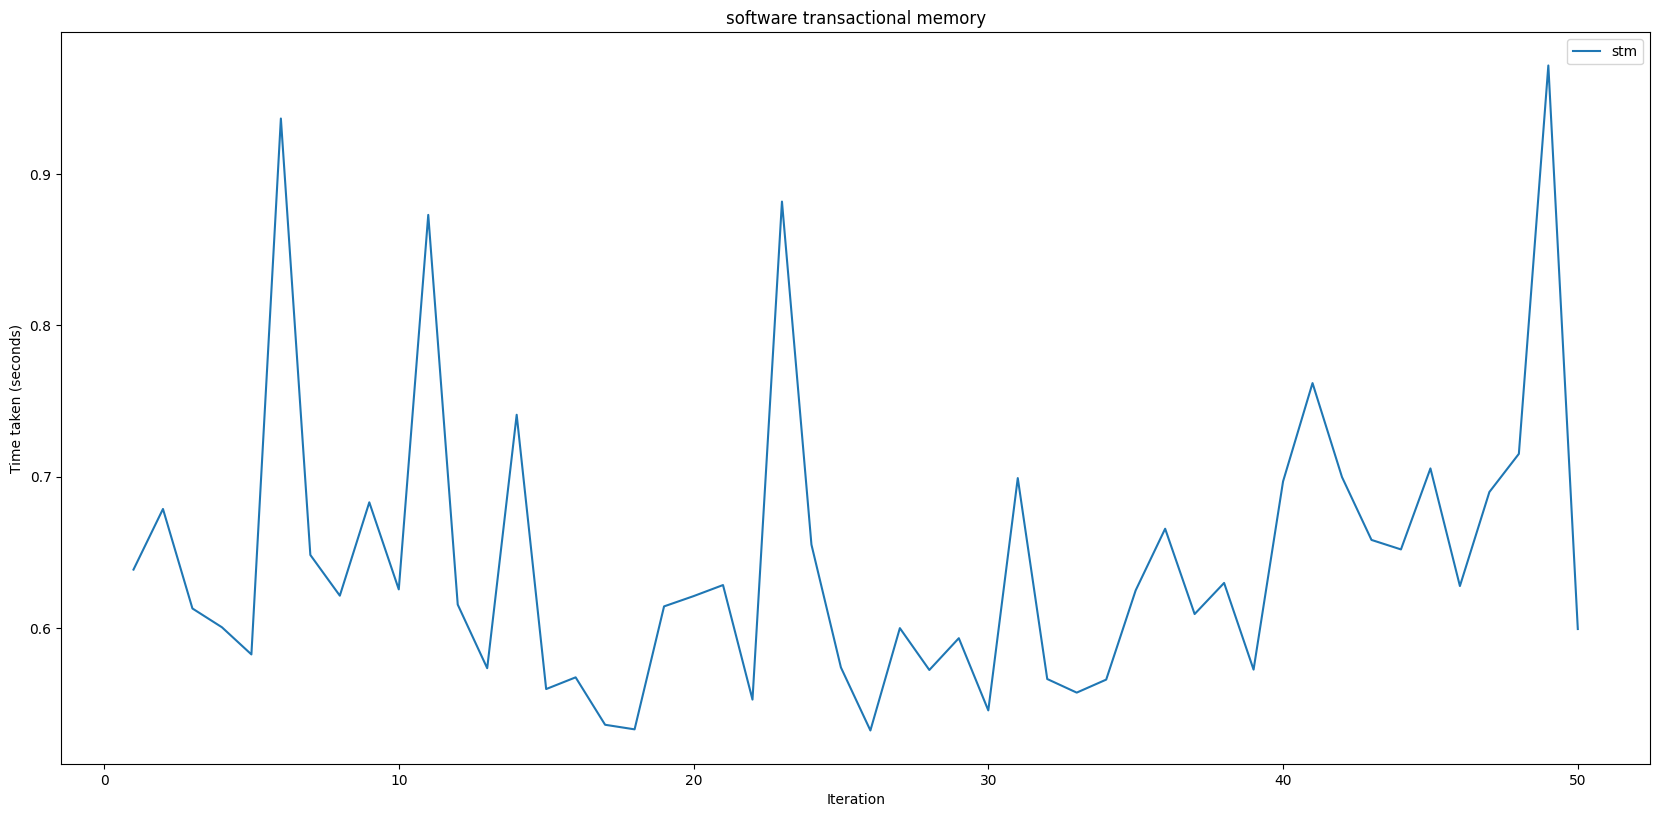

In [7]:
fig, ax = plt.subplots()
fig.set_size_inches(20.5, 9.5)
ax.plot(range(1, iterations+1), times, label='stm')
ax.set_xlabel('Iteration')
ax.set_ylabel('Time taken (seconds)')

ax.set_title('software transactional memory')
ax.legend()
plt.show()